In [467]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Literal, List, Set
from functools import reduce
from time import perf_counter

In [468]:
# Define unitary gates

# Paulis
def I(nstates: int=2):
    return np.asmatrix(np.identity(nstates, dtype=complex))

def X():
    return np.matrix([
        [0, 1],
        [1, 0],
    ], dtype=complex)

def Y():
    return np.matrix([
        [ 0, -1j],
        [1j,   0],
    ], dtype=complex)

def Z():
    return np.matrix([
        [1,  0],
        [0, -1],
    ], dtype=complex)

# Single-qubit rotations
def Rot_X(theta):
    return np.cos(theta / 2) * I() - 1j * X() * np.sin(theta / 2)

def Rot_Y(theta):
    return np.cos(theta / 2) * I() - 1j * Y() * np.sin(theta / 2)

def Rot_Z(theta):
    return np.cos(theta / 2) * I() - 1j * Z() * np.sin(theta / 2)

# Hadamard
def H():
    return 1/np.sqrt(2) * np.matrix([
        [1,  1],
        [1, -1],
    ], dtype=complex)

# Two-qubit gates
def SWAP():
    return np.matrix([
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
    ], dtype=complex)

def CNOT():
    return np.matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
    ], dtype=complex)

def CZ():
    p = -1
    return np.matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, p],
    ], dtype=complex)

def CPHASE(theta):
    p = np.exp(1j * theta)
    return np.matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, p],
    ], dtype=complex)

In [469]:
class Gate:
    """
    Wrapper class for unitary matrices used as quantum gates.
    Can be applied only on Density Matrices.

    TODO: use the functions wrapping U instead of the actual matrix for U
    
    Attributes
    ----------
    U: :class:`numpy.matrix`
        Unitary matrix of this gate
    """
    def __init__(self, U: np.matrix):
        self.U = U

    def __call__(self, rho: np.matrix):
        return self.U @ rho @ self.U.H
    
    def __str__(self):
        return str(self.U)
    

# TODO: For now Moment is just an alias for Gate, 
# but, in the future (i.e., on a sunny day), 
# it is envisioned to have a different purpose.
Moment = Gate  


class QuantumCircuit:
    """
    Class encapsulating a sequence of `Gate`s to be applied on a given initial state.
    
    Attributes
    ----------
    gates: list[:class:`Gate`]
        Sequence of gates
    """

    def __init__(self, gates: List[Gate]):
        self.gates = gates

    def __call__(self, rho):
        return reduce(lambda dm, gate: gate(dm), self.gates, rho)

In [470]:
# Define trace-preserving operations

class DepolarizingChannel:
    """Depolarizing channel for 2-qubit state (in Density Matrix form)."""

    def __init__(self, p: float):
        assert 0 <= p <= 1
        self.p = p

    def __call__(self, rho: np.matrix, nstates: int=None):
        nrows, ncols = np.shape(rho)
        assert nrows == ncols, \
            'Depolarizing channel can be applied only to density matrices'
        if nstates is None:
            nstates = nrows
        return self.p * rho + (1 - self.p) / nstates * I(nstates)
    

class PartialTrace:
    """
    Computes the partial trace over a given density matrix.

    Attributes
    ----------
    nqubits: `int`
        Total number of qubits in the system

    out_qubits: `list[int]`
        Indices of qubits to be traced out
    """
    
    def __init__(self, nqubits: int, out_qubits: List[int]):
        self.nqubits = nqubits
        self.out_qubits = set(out_qubits)
    
    def __call__(self, rho: np.matrix):

        comp_bases = POVM._get_comp_bases(
            len(self.out_qubits)
        )

        def reduce_func(accum, basis):
            M = kron([
                next(basis) if i in self.out_qubits else I() 
                for i in range(self.nqubits)
            ])
            return accum + (M.H @ rho @ M)

        return reduce(reduce_func, comp_bases, 0)
    

class POVM:
    """
    Constructs a POVM to be used in measuring selected qubits.

    Attributes
    ----------
    nqubits: `int`
        Total number of qubits in the system

    meas_qubits: `list[int]`
        Indices of qubits to be measured
    
    partial_trace: `bool`, optional, default `False`
        Whether to automatically trace out measured qubits
    """

    def __init__(self, 
        nqubits: int, 
        meas_qubits: List[int],
        partial_trace: bool=False
    ):
        self.nqubits = nqubits
        self.meas_qubits = set(meas_qubits)
        self.partial_trace = partial_trace

    def __call__(self, rho: np.matrix):

        Ms = POVM._create_povm(
            self.nqubits, 
            self.meas_qubits,
            self.partial_trace,
        )

        probs = []
        rho_outs = []

        for M in Ms:
            prob = 0.0
            if self.partial_trace:
                prob = np.real(np.trace(M.H @ rho @ M))
            else:
                prob = np.real(np.trace(rho @ M))
            
            rho_out = M.H @ rho @ M
            rho_out = rho_out / prob if prob else rho_out  # Normalize

            probs.append(prob)
            rho_outs.append(rho_out)

        return np.array(probs), np.array(rho_outs)

    @staticmethod
    def _get_comp_bases(nqubits: int):
        # NOTE: this function evaluates lazily!
        BASE = [comp_state(0), comp_state(1)]
        return iter(
            iter(BASE[(i >> j) & 1] for j in range(nqubits))
            for i in range(2 ** nqubits)
        )
    
    @staticmethod
    def _create_povm(
        nqubits: int, 
        meas_qubits: Set[int],
        partial_trace: bool,
    ):
        # NOTE: this function evaluates lazily!
        comp_bases = POVM._get_comp_bases(len(meas_qubits))

        if partial_trace:
            foo = lambda ket: ket  # Ket to Ket
        else:
            foo = lambda ket: ket @ ket.H  # Ket to Density Matrix

        def map_func(basis):
            return kron([
                foo(next(basis)) if i in meas_qubits else I() 
                for i in range(nqubits)
            ])

        return map(map_func, comp_bases)

In [471]:
# Define some additional helpful operations

def kron(As: List[np.matrix]):
    """Kronecker product"""
    # NOTE: here, kron with foldr is faster than with foldl (i.e., reduce)
    return reduce(lambda accum, A: np.kron(A, accum), reversed(As), 1)

def fidelity(dm: np.matrix, ket: np.matrix):
    """Compute fidelity between a density matrix and a ket state."""
    f = np.trace(ket.H @ dm @ ket)  # use trace because f is wrapped in a matrix
    assert np.imag(f) == 0
    return np.real(f)

In [472]:
def comp_state(n: int, nstates: int=2):
    assert 0 <= n < nstates
    psi = np.zeros(nstates, dtype=complex)
    psi[n] = 1.0
    return np.asmatrix(psi).T

def bell_state(a: Literal[0, 1]=0, b: Literal[0, 1]=0):
    phi = 1/np.sqrt(2) * np.matrix([1, 0, 0, 1], dtype=complex).T
    if b:
        phi = kron([I(), Z()]) @ phi
    if a:
        phi = kron([I(), X()]) @ phi
    return phi

def werner_state(p: float):
    phi_00 = bell_state(0, 0)
    rho_00 = phi_00 @ phi_00.H
    return DepolarizingChannel(p)(rho_00)

In [473]:
# Define U_A, U_B unitaries
U_A = Rot_X(np.pi / 2)
U_B = Rot_X(- np.pi / 2)

# Create DEJMPS circuit
dejmps_circuit = QuantumCircuit([
    Gate(kron([U_A, U_B, U_A, U_B])),   # Apply U_A, U_B gates on each EPR pair
    Gate(kron([I(), SWAP(), I()])),     # Swap qubits 1B, 2A (arange qubits in order: |1A, 2A, 1B, 2B>)
    Gate(kron([CNOT(), CNOT()])),       # Apply CNOT(1A, 2A) and CNOT(1B, 2B)
    Gate(kron([I(), SWAP(), I()])),     # Swap back qubits 2A, 1B (rearange qubits in order: |1A, 1B, 2A, 2B>)
])

# Construct POVM for the 2nd EPR pair
povm_epr2 = POVM(
    nqubits=4, 
    meas_qubits=[2, 3], 
    partial_trace=True,
)

In [474]:
results = []

for epr_channel_fidelity in np.linspace(0, 1, 11):
    # Create two EPR pairs between Alice and Bob
    epr_1 = epr_2 = werner_state(epr_channel_fidelity)

    # Create ensemble of two EPR pairs 
    # (qubits in order: |1A, 1B, 2A, 2B>)
    rho = kron([epr_1, epr_2])

    # Apply DEJMPS circuit
    rho = dejmps_circuit(rho)

    # Compute probabilities and outcome states 
    # when measuring qubits 2A and 2B
    probs, rho_outs = povm_epr2(rho)

    # Compute fidelity wrt. the Bell state phi_00
    target_state = bell_state()
    fidels = np.array([fidelity(dm, target_state) for dm in rho_outs])

    # Compute probability of success and average fidelity **given** success
    prob_succ = probs[0] + probs[-1]
    fidel_succ = (fidels[0] * probs[0] + fidels[-1] * probs[-1]) / prob_succ

    results.append([epr_channel_fidelity, prob_succ, fidel_succ])

results = np.array(results)

In [475]:
def series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concat(row) for row in s.items()])

def get_prob_succ_mean_sd(df: pd.DataFrame):
    """Computes the mean and standard deviation for the success probability."""
    return [
        1 - (df['M_Alice'] ^ df['M_Bob']).mean(), 
        (df['M_Alice'] ^ df['M_Bob']).std(),
    ]

def get_fidel_succ_mean_sd(df: pd.DataFrame):
    """Computes the mean and the standard deviation for the fidelity given success"""
    return [
        df.query('M_Alice == M_Bob')['Fidelity'].mean(), 
        df.query('M_Alice == M_Bob')['Fidelity'].std(),
    ]

# Read simulation results
data = pd.read_csv('./out.csv')

# Group data by gate and channel fidelity
data = data.groupby(['Gate fidelity', 'EPR channel fidelity'])\

# Compute mean and sd for the success probability
p_succ_mean_sd = data.apply(get_prob_succ_mean_sd, include_groups=False)
p_succ_mean_sd = series_to_numpy(p_succ_mean_sd)

# Compute mean and sd for the success fidelity
f_succ_mean_sd = data.apply(get_fidel_succ_mean_sd, include_groups=False)
f_succ_mean_sd = series_to_numpy(f_succ_mean_sd)

print(p_succ_mean_sd)
print(f_succ_mean_sd)

[[0.69       0.69       0.66666667 0.57735027]
 [1.         0.8        0.92       0.27265992]]
[[0.69       0.69       0.75       0.07071068]
 [1.         0.8        0.86956522 0.33862655]]


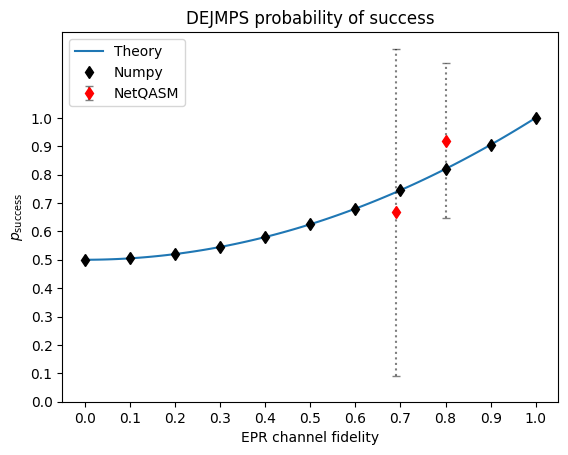

In [476]:
# The probability of measuring a = b is given by the following function:
def prob_succ_theory(epr_channel_fidelity):
    """Theoretical formula for the DEJMPS probability of success"""
    return (1 + epr_channel_fidelity ** 2) / 2

ps = np.linspace(0, 1, 101)

plt.plot(ps, prob_succ_theory(ps), label='Theory')

plt.plot(results[:,0], results[:,1], 'd', color='black', label='Numpy')

markers, caps, bars = plt.errorbar(
    p_succ_mean_sd[:,1], p_succ_mean_sd[:,2], yerr=p_succ_mean_sd[:,3],
    capsize=3, fmt="rd", ecolor = "black", label='NetQASM',
)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
[bar.set_linestyle(':') for bar in bars]

plt.title('DEJMPS probability of success')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

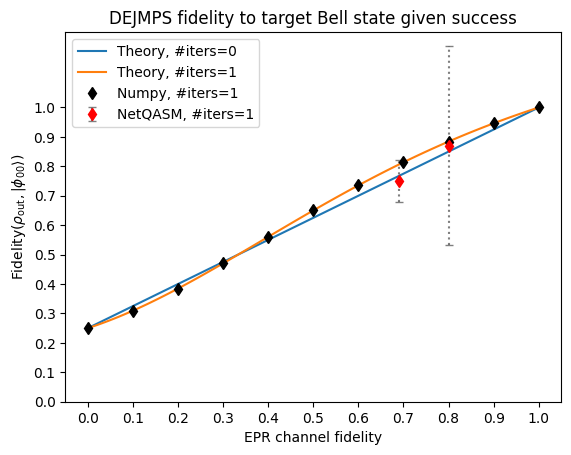

In [477]:
def initial_fidelity(p):
    return (1 + 3 * p) / 4

def fidelity_succ_theory(p, niters: int=0):
    """Theoretical formula for the DEJMPS fidelity given protocol success"""
    dm = werner_state(p)
    A = fidelity(dm, bell_state(0, 0))
    B = fidelity(dm, bell_state(1, 1))
    C = fidelity(dm, bell_state(1, 0))
    D = fidelity(dm, bell_state(0, 1))

    for _ in range(niters):
        N = (A + B) ** 2 + (C + D) ** 2
        A = (A ** 2 + B ** 2) / N
        B = (2 * C * D) / N
        C = (C ** 2 + D ** 2) / N
        D = (2 * A * B) / N

    return A

ps = np.linspace(0, 1, 101)

for niters in range(0, 2):
    plt.plot(ps, [fidelity_succ_theory(p, niters) for p in ps], label=f'Theory, #iters={niters}')

plt.plot(results[:,0], results[:,2], 'd', color='black', label='Numpy, #iters=1')

markers, caps, bars = plt.errorbar(
    f_succ_mean_sd[:,1], f_succ_mean_sd[:,2], yerr=f_succ_mean_sd[:,3],
    capsize=3, fmt="rd", ecolor = "black", label='NetQASM, #iters=1',
)
[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]
[bar.set_linestyle(':') for bar in bars]

plt.title('DEJMPS fidelity to target Bell state given success')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()